<a href="https://colab.research.google.com/github/SkandarEverest/praktikum_ml/blob/main/23525009_23525046_IF5140_Praktikum_6_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [ ]:
!gdown 1kbiDYHGMAGWMCVhePtwkXEsE9aCgGemi

Downloading...
From: https://drive.google.com/uc?id=1kbiDYHGMAGWMCVhePtwkXEsE9aCgGemi
To: /content/Stock.csv
100% 321k/321k [00:00<00:00, 125MB/s]


In [ ]:
df = pd.read_csv("Stock.csv", sep=";")
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,12/01/2025,283.10,278.01,283.40,276.17,41.46M,1.52%
1,11/28/2025,278.85,277.26,279.00,275.99,20.14M,0.47%
2,11/26/2025,277.55,276.96,279.53,276.63,33.43M,0.21%
3,11/25/2025,276.97,275.27,280.38,275.25,46.91M,0.38%
4,11/24/2025,275.92,270.90,277.00,270.90,65.59M,1.63%


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6518 entries, 0 to 6517
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      6518 non-null   object 
 1   Price     6518 non-null   float64
 2   Open      6518 non-null   float64
 3   High      6518 non-null   float64
 4   Low       6518 non-null   float64
 5   Vol.      6518 non-null   object 
 6   Change %  6518 non-null   object 
dtypes: float64(4), object(3)
memory usage: 356.6+ KB


In [ ]:
df["Date"] = pd.to_datetime(df["Date"])
df.index = df["Date"]
df.drop("Date", axis=1, inplace=True)
df.sort_index(inplace=True)

In [ ]:
df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2000-01-03,1.00,0.94,1.00,0.91,535.82M,8.88%
2000-01-04,0.92,0.97,0.99,0.90,511.73M,-8.43%
2000-01-05,0.93,0.93,0.99,0.92,778.32M,1.46%
2000-01-06,0.85,0.95,0.96,0.85,767.98M,-8.65%
2000-01-07,0.89,0.86,0.90,0.85,460.73M,4.74%


In [ ]:
df.drop(columns=["Open", "High", "Low", "Vol.", "Change %"], inplace=True)

# Exploratory Data Analysis

In [ ]:
df.describe()

,Price
count,6518.000000
mean,49.244254
std,68.668181
min,0.230000
25%,2.550000
50%,18.375000
75%,52.590000
max,283.100000


In [ ]:
df.isnull().sum()

,0
Price,0


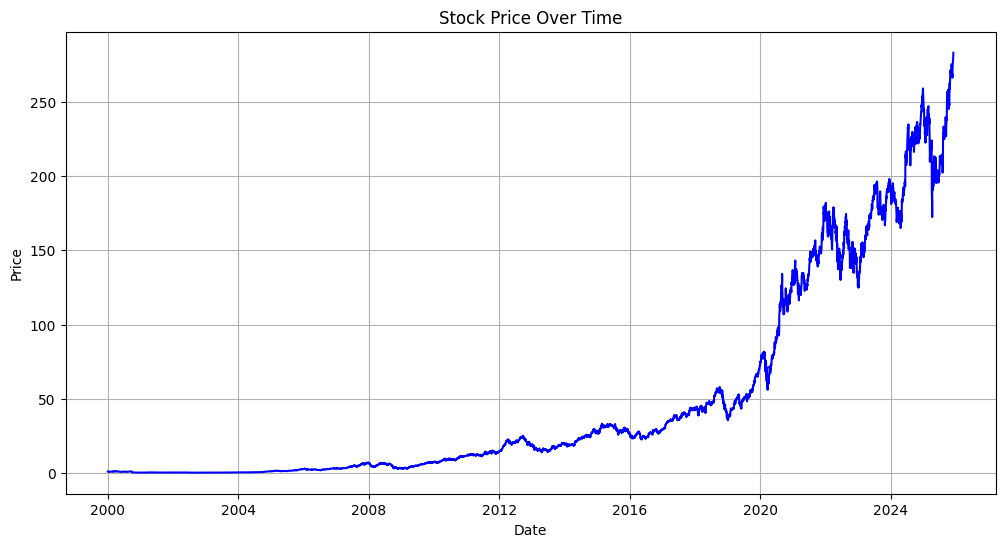

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(df.index, df['Price'], color='blue')
plt.title('Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.grid(True)
plt.show()

<Axes: xlabel='Price', ylabel='Count'>

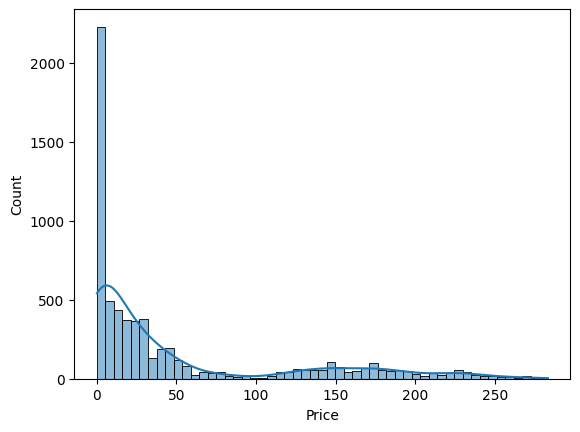

In [ ]:
sns.histplot(df["Price"], kde=True)

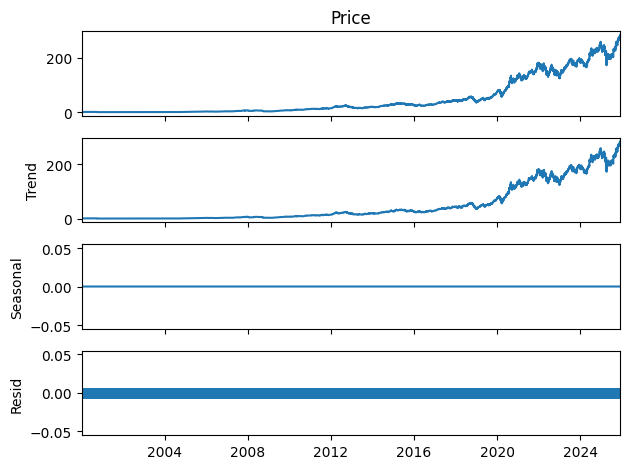

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose

seasonal_decompose(df["Price"], period=1).plot()
plt.show()

In [ ]:
from statsmodels.tsa.stattools import adfuller

adfuller_result = adfuller(df["Price"])

print(f"P-Value: {round(adfuller_result[1], 4)}")

P-Value: 0.9991


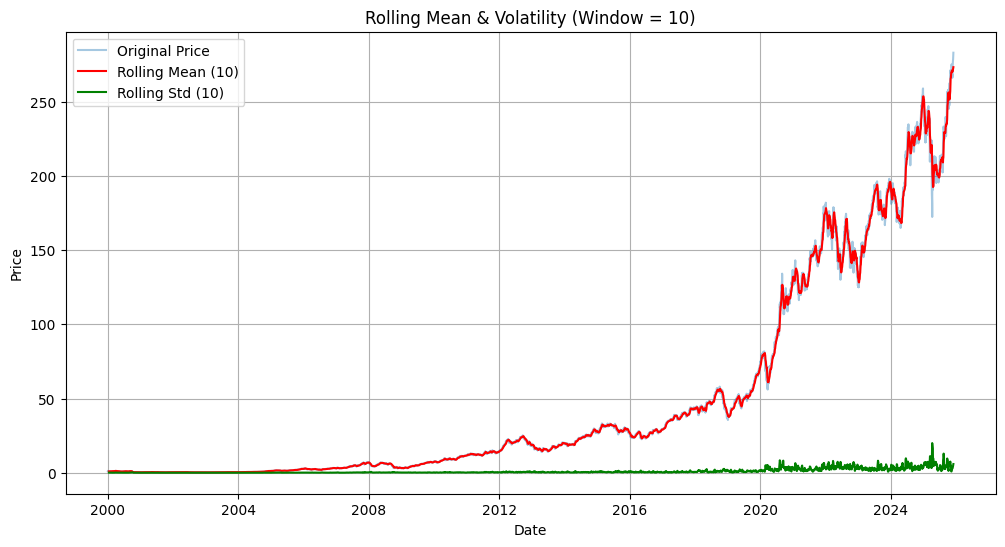

In [ ]:
plt.figure(figsize=(12, 6))

rolling_mean = df["Price"].rolling(window=10).mean()
rolling_std = df["Price"].rolling(window=10).std()

plt.plot(df.index, df["Price"], label="Original Price", alpha=0.4)
plt.plot(df.index, rolling_mean, label="Rolling Mean (10)", color='red')
plt.plot(df.index, rolling_std, label="Rolling Std (10)", color='green')

plt.title("Rolling Mean & Volatility (Window = 10)")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.show()


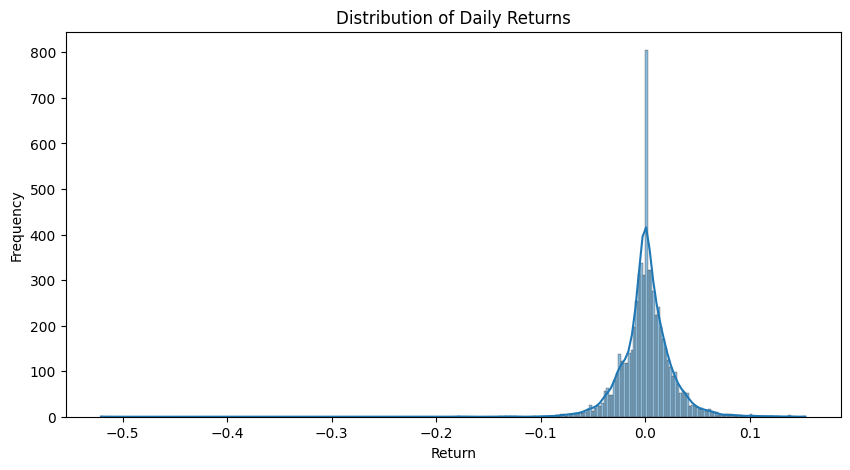

In [ ]:
returns = df["Price"].pct_change()

plt.figure(figsize=(10, 5))
sns.histplot(returns.dropna(), kde=True)
plt.title("Distribution of Daily Returns")
plt.xlabel("Return")
plt.ylabel("Frequency")
plt.show()


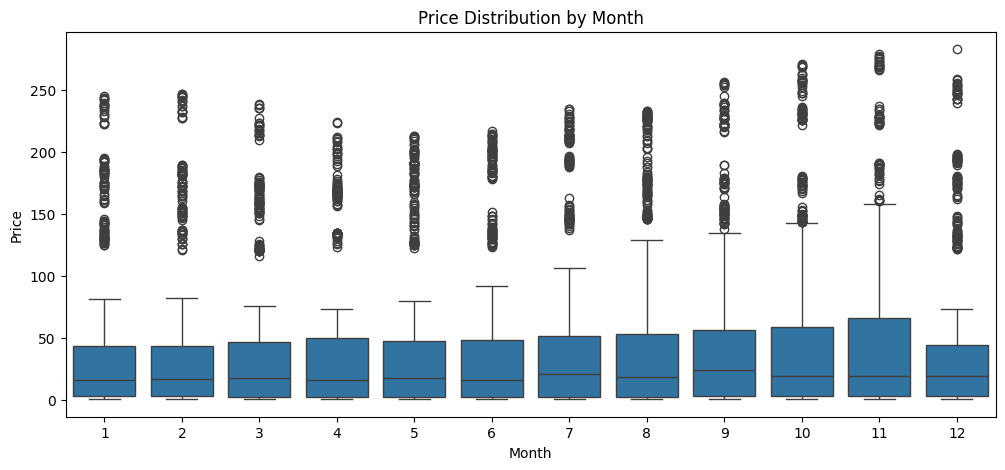

In [ ]:
df["Month"] = df.index.month
plt.figure(figsize=(12, 5))
sns.boxplot(x="Month", y="Price", data=df)
plt.title("Price Distribution by Month")
plt.show()


### Windowing Function

In [ ]:
def windowed_dataset(series, window_size, target_window, batch_size):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + target_window, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + target_window))
    ds = ds.map(lambda w: (w[:window_size], w[window_size:]))
    return ds.batch(batch_size)

### Eval Function

In [ ]:
def eval_plot_mae_rmse(history, test_index, window_size, y_actual, y_pred):
    y_actual_arr = np.asarray(y_actual).reshape(-1)
    y_pred_arr   = np.asarray(y_pred).reshape(-1)

    # 1) Loss curves
    plt.plot(history.epoch, history.history["loss"], label="Loss")
    plt.plot(history.epoch, history.history["val_loss"], label="Validation Loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

    # 2) Metrics
    mae = float(np.mean(np.abs(y_actual_arr - y_pred_arr)))
    rmse = float(np.sqrt(np.mean((y_actual_arr - y_pred_arr) ** 2)))

    # 3) Plot akurasi
    x_idx = test_index[window_size:window_size + len(y_actual_arr)]

    plt.plot(x_idx, y_actual_arr, label="Actual")
    plt.plot(x_idx, y_pred_arr, label="Predicted")
    plt.legend()
    plt.title("Actual vs Predicted")
    plt.show()

    return {"MAE": mae, "RMSE": rmse}


In [ ]:
def get_y_actual_from_windowed_ds(ds, scaler):
    ys = []
    for _, y in ds:
        y_np = y.numpy()
        y_np = y_np.reshape(-1, 1)
        ys.append(y_np)

    y_scaled_2d = np.concatenate(ys, axis=0)
    y_actual = scaler.inverse_transform(y_scaled_2d)
    return y_actual

# ALL Data

## Data Preprocessing

In [ ]:
train_split = 0.8
train = df[:int(train_split * len(df))]
test = df[int(train_split * len(df)):]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train)
X_train = scaler.transform(train)
X_test = scaler.transform(test)

In [ ]:
WINDOW_SIZE = 10
train_ds = windowed_dataset(X_train.squeeze(1), WINDOW_SIZE, 1, 8)
test_ds = windowed_dataset(X_test.squeeze(1), WINDOW_SIZE, 1, 8)

In [ ]:
for i, j in train_ds.take(1):
    print(i.numpy().shape)
    print(j.numpy().shape)

(8, 10, 1)
(8, 1, 1)


## RNN

### Base model

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,177 (8.50 KB)

 Trainable params: 2,177 (8.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
    630/Unknown 3s 3ms/step - loss: 2.4232e-05

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.8246e-05 - val_loss: 0.1396
Epoch 2/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0016 - val_loss: 0.0677
Epoch 3/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.0012 - val_loss: 0.0807
Epoch 4/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0013 - val_loss: 0.0785
Epoch 5/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0015 - val_loss: 0.0275
Epoch 6/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.1363e-04 - val_loss: 0.0246
Epoch 7/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.8526e-05 - val_loss: 0.0199
Epoch 8/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 11s 17ms/step - loss: 8.3937e-05 - val_loss: 0.0198
Epoch 9/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.1631e-05 - val_loss: 0.0178
Epoch 10/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.3364e-04 - val_loss: 0.0213
162/162 ━━━━━━━━━━━━━━━━━━━━ 8s 2ms/step


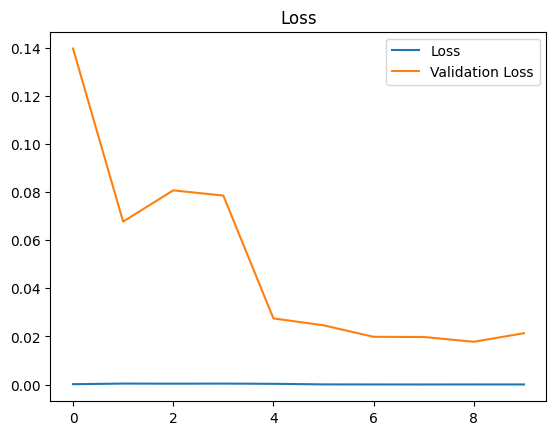

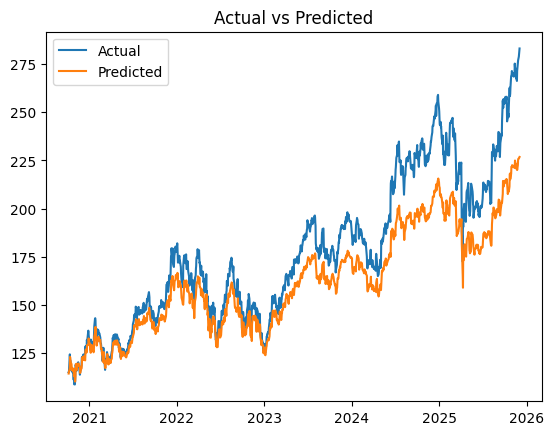

{'MAE': 15.379623806701378, 'RMSE': 19.568238735840538}

In [ ]:
# base
rnn_model_base = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, 1)),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])
rnn_model_base.summary()

rnn_model_base.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
)

history_base = rnn_model_base.fit(train_ds, validation_data=test_ds, epochs=10)

pred = rnn_model_base.predict(test_ds)
pred = scaler.inverse_transform(pred)

y_actual = get_y_actual_from_windowed_ds(test_ds, scaler)

metrics = eval_plot_mae_rmse(history_base, test.index, WINDOW_SIZE, y_actual, pred)
metrics

### Eksperimen (a): Jumlah neuron pada RNN layer

#### Modelling

Epoch 1/10
    631/Unknown 3s 3ms/step - loss: 3.0946e-05

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


651/651 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 3.5715e-05 - val_loss: 0.0650
Epoch 2/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0049 - val_loss: 0.0446
Epoch 3/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.0037 - val_loss: 0.0291
Epoch 4/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.4074e-04 - val_loss: 0.0233
Epoch 5/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.9251e-04 - val_loss: 0.0133
Epoch 6/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.9878e-05 - val_loss: 0.0115
Epoch 7/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 6.8158e-05 - val_loss: 0.0123
Epoch 8/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 8.5062e-05 - val_loss: 0.0135
Epoch 9/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.3248e-04 - val_loss: 0.0119
Epoch 10/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.9041e-04 - val_loss: 0.0115
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


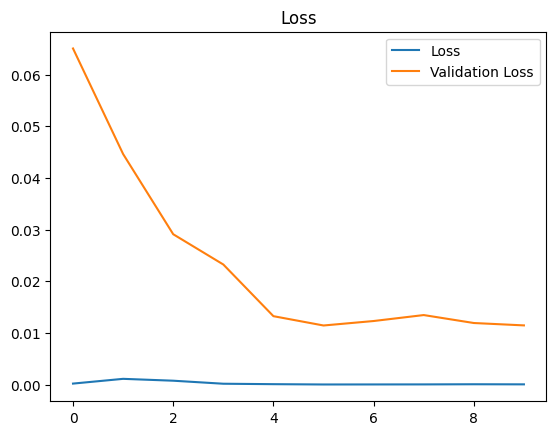

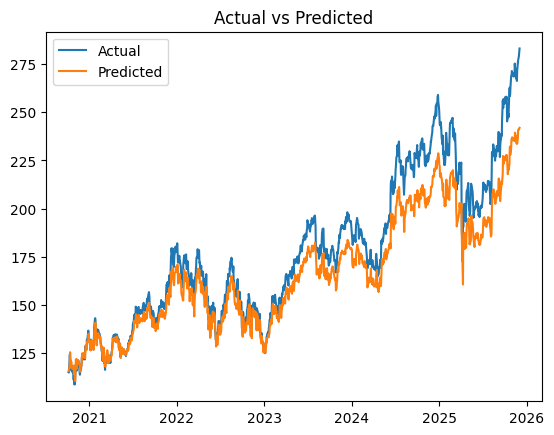

{'MAE': 11.303089881908765, 'RMSE': 14.348388675771371}

In [ ]:
# Units = 16
rnn_model_u16 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, 1)),
    tf.keras.layers.SimpleRNN(16),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])
rnn_model_u16.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
)

history_u16 = rnn_model_u16.fit(train_ds, validation_data=test_ds, epochs=10)

pred = rnn_model_u16.predict(test_ds)
pred = scaler.inverse_transform(pred)

y_actual = get_y_actual_from_windowed_ds(test_ds, scaler)

metrics = eval_plot_mae_rmse(history_u16, test.index, WINDOW_SIZE, y_actual, pred)
metrics

Epoch 1/10
    645/Unknown 3s 3ms/step - loss: 2.2918e-05

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.3481e-05 - val_loss: 0.0406
Epoch 2/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 3.8476e-04 - val_loss: 0.0435
Epoch 3/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.5269e-04 - val_loss: 0.0431
Epoch 4/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.4768e-04 - val_loss: 0.0195
Epoch 5/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0015 - val_loss: 0.0440
Epoch 6/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0013 - val_loss: 0.0173
Epoch 7/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - loss: 0.0013 - val_loss: 0.0101
Epoch 8/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.3734e-04 - val_loss: 0.0092
Epoch 9/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 9.2810e-04 - val_loss: 0.0090
Epoch 10/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.7703e-04 - val_loss: 0.0265
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


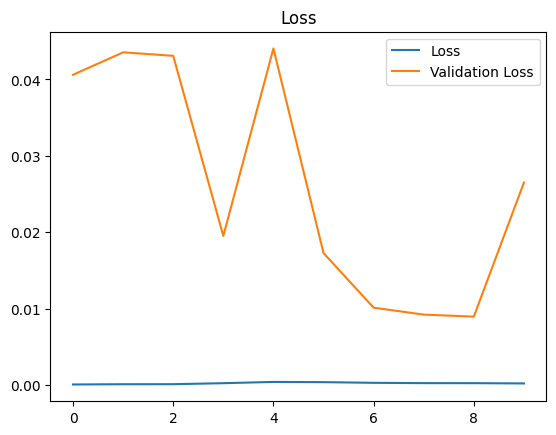

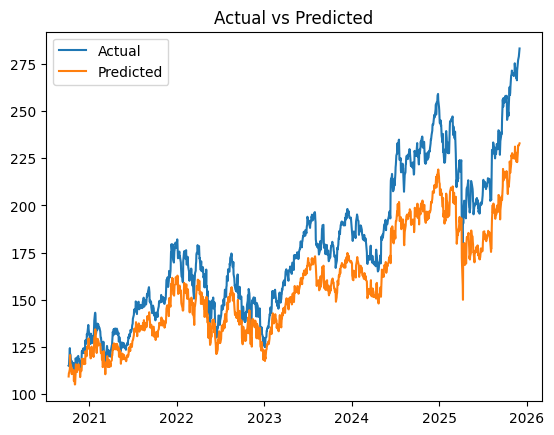

{'MAE': 19.245889068320512, 'RMSE': 21.805636845580967}

In [ ]:
# Units = 64
rnn_model_u64 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, 1)),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])
rnn_model_u64.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
)

history_u64 = rnn_model_u64.fit(train_ds, validation_data=test_ds, epochs=10)

pred = rnn_model_u64.predict(test_ds)
pred = scaler.inverse_transform(pred)

y_actual = get_y_actual_from_windowed_ds(test_ds, scaler)

metrics = eval_plot_mae_rmse(history_u64, test.index, WINDOW_SIZE, y_actual, pred)
metrics


#### Analisis

Variasi jumlah neuron menunjukkan perubahan performa yang cukup jelas. Model dengan 16 unit memberikan hasil terbaik pada percobaan ini (MAE 11.30; RMSE 14.35), mengungguli baseline 32 unit (MAE 15.38; RMSE 19.57). Sebaliknya, peningkatan jumlah neuron menjadi 64 unit justru menurunkan performa (MAE 19.25; RMSE 21.81). Hal ini menunjukkan bahwa kapasitas model yang terlalu besar tidak selalu menguntungkan, dan jumlah neuron yang lebih kecil sudah cukup untuk mempelajari pola harga jangka pendek.

### Eksperimen (b): Jumlah RNN layer

#### Modelling

Epoch 1/10
    644/Unknown 4s 4ms/step - loss: 3.9950e-05

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


651/651 ━━━━━━━━━━━━━━━━━━━━ 5s 5ms/step - loss: 4.1534e-05 - val_loss: 0.1943
Epoch 2/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0019 - val_loss: 0.1997
Epoch 3/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0014 - val_loss: 0.1224
Epoch 4/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0073 - val_loss: 0.0796
Epoch 5/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0051 - val_loss: 0.0651
Epoch 6/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0026 - val_loss: 0.0850
Epoch 7/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 7.2418e-04 - val_loss: 0.0505
Epoch 8/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 0.0011 - val_loss: 0.0593
Epoch 9/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 8.4547e-04 - val_loss: 0.0896
Epoch 10/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0024 - val_loss: 0.2274
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


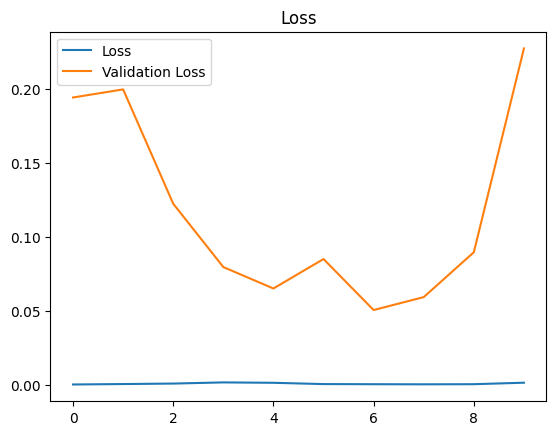

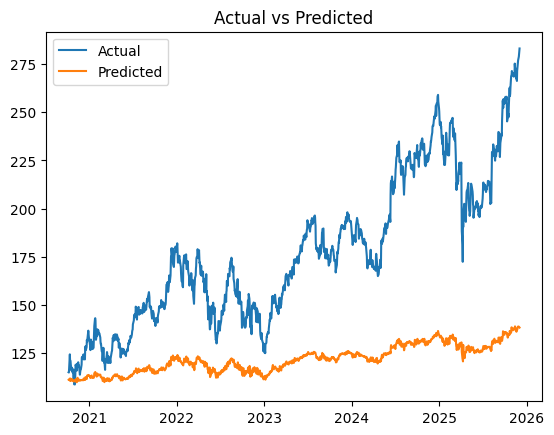

{'MAE': 55.40773198595003, 'RMSE': 63.87890921380927}

In [ ]:
# 2 RNN layers (32 units)
rnn_model_rnn2 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, 1)),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])
rnn_model_rnn2.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
)

history_rnn2 = rnn_model_rnn2.fit(train_ds, validation_data=test_ds, epochs=10)

pred = rnn_model_rnn2.predict(test_ds)
pred = scaler.inverse_transform(pred)

y_actual = get_y_actual_from_windowed_ds(test_ds, scaler)

metrics_rnn2 = eval_plot_mae_rmse(history_rnn2, test.index, WINDOW_SIZE, y_actual, pred)
metrics_rnn2


Epoch 1/10
    644/Unknown 6s 6ms/step - loss: 6.9240e-05

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


651/651 ━━━━━━━━━━━━━━━━━━━━ 7s 7ms/step - loss: 7.2799e-05 - val_loss: 0.3817
Epoch 2/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0067 - val_loss: 0.2905
Epoch 3/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0016 - val_loss: 0.2224
Epoch 4/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0011 - val_loss: 0.1825
Epoch 5/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.0010 - val_loss: 0.1910
Epoch 6/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 3.9214e-04 - val_loss: 0.1815
Epoch 7/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 2.0286e-04 - val_loss: 0.2050
Epoch 8/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 6.1368e-04 - val_loss: 0.1679
Epoch 9/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 5.7490e-04 - val_loss: 0.1517
Epoch 10/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 1.4706e-04 - val_loss: 0.1860
162/162 ━━━━━━━━━━━━━━━━━━━━ 8s 3ms/step


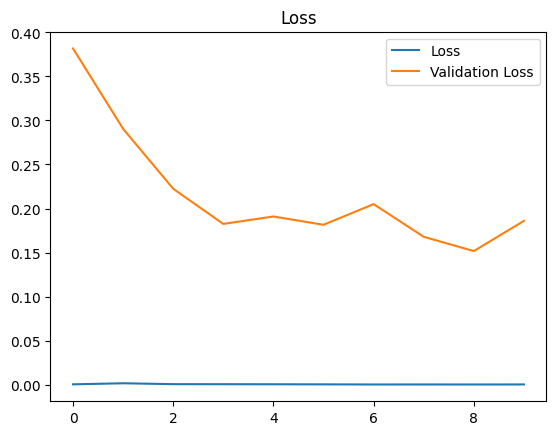

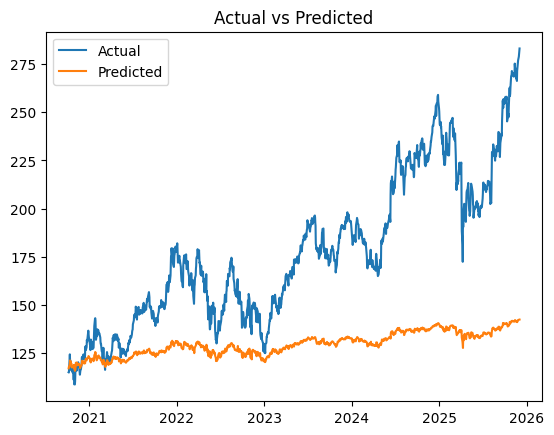

{'MAE': 47.606004743620275, 'RMSE': 57.76577043383667}

In [ ]:
# 3 RNN layers (32 units)
rnn_model_rnn3 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, 1)),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])
rnn_model_rnn3.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
)

history_rnn3 = rnn_model_rnn3.fit(train_ds, validation_data=test_ds, epochs=10)

pred = rnn_model_rnn3.predict(test_ds)
pred = scaler.inverse_transform(pred)

y_actual = get_y_actual_from_windowed_ds(test_ds, scaler)

metrics_rnn3 = eval_plot_mae_rmse(history_rnn3, test.index, WINDOW_SIZE, y_actual, pred)
metrics_rnn3


#### Analisis

Penambahan jumlah lapisan RNN secara konsisten memperburuk performa. Model dua lapisan menghasilkan MAE 55.41 dan RMSE 63.88, sedangkan tiga lapisan juga menunjukkan error yang sangat tinggi (MAE 47.61; RMSE 57.77). Hasil ini menunjukkan bahwa SimpleRNN tidak stabil ketika dibuat lebih dalam, sehingga satu lapisan RNN menjadi pilihan yang paling sesuai untuk dataset ini.

### Eksperimen (c): Dense layer & neuron

#### Modelling

Epoch 1/10
    640/Unknown 30s 3ms/step - loss: 7.8902e-06

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


651/651 ━━━━━━━━━━━━━━━━━━━━ 31s 4ms/step - loss: 8.4158e-06 - val_loss: 0.0363
Epoch 2/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 2.7589e-04 - val_loss: 0.0649
Epoch 3/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 4.2754e-04 - val_loss: 0.0270
Epoch 4/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 7.2686e-04 - val_loss: 0.0108
Epoch 5/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - loss: 2.3479e-04 - val_loss: 0.0093
Epoch 6/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 1.4427e-04 - val_loss: 0.0093
Epoch 7/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.0142e-05 - val_loss: 0.0091
Epoch 8/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - loss: 1.9259e-04 - val_loss: 0.0078
Epoch 9/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.3907e-04 - val_loss: 0.0092
Epoch 10/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.3301e-04 - val_loss: 0.0092
162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


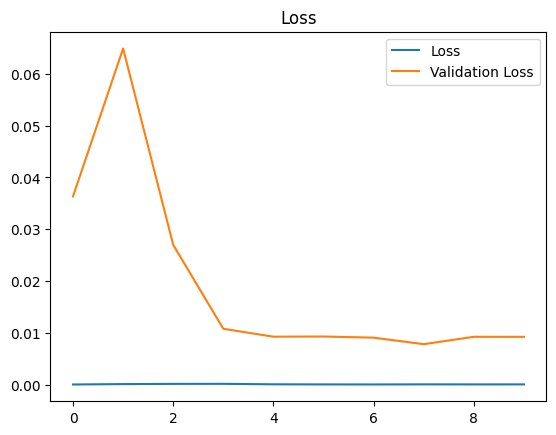

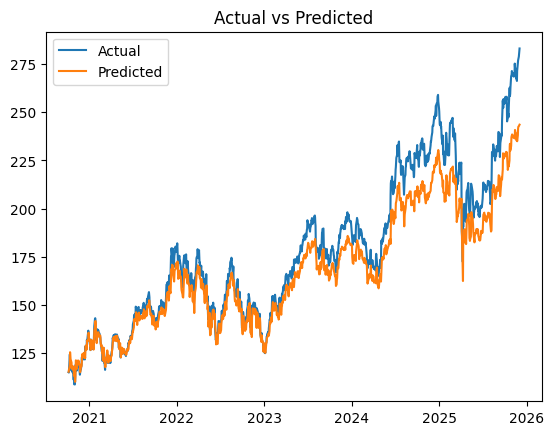

{'MAE': 9.825664643135838, 'RMSE': 12.871470347220962}

In [ ]:
# Dense = 0 (langsung output)
rnn_model_dense0 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, 1)),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1),
])
rnn_model_dense0.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
)

history_dense0 = rnn_model_dense0.fit(train_ds, validation_data=test_ds, epochs=10)

pred = rnn_model_dense0.predict(test_ds)
pred = scaler.inverse_transform(pred)

y_actual = get_y_actual_from_windowed_ds(test_ds, scaler)

metrics_dense0 = eval_plot_mae_rmse(history_dense0, test.index, WINDOW_SIZE, y_actual, pred)
metrics_dense0


Epoch 1/10
    637/Unknown 3s 3ms/step - loss: 2.5153e-05

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.7690e-05 - val_loss: 0.2329
Epoch 2/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 9.8096e-04 - val_loss: 0.0722
Epoch 3/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0011 - val_loss: 0.0911
Epoch 4/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.8800e-04 - val_loss: 0.0731
Epoch 5/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 4.3311e-04 - val_loss: 0.0387
Epoch 6/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.4406e-04 - val_loss: 0.0398
Epoch 7/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 9.2782e-05 - val_loss: 0.0349
Epoch 8/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.6564e-04 - val_loss: 0.0389
Epoch 9/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.1220e-04 - val_loss: 0.0388
Epoch 10/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 4.2979e-04 - val_loss: 0.0437
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


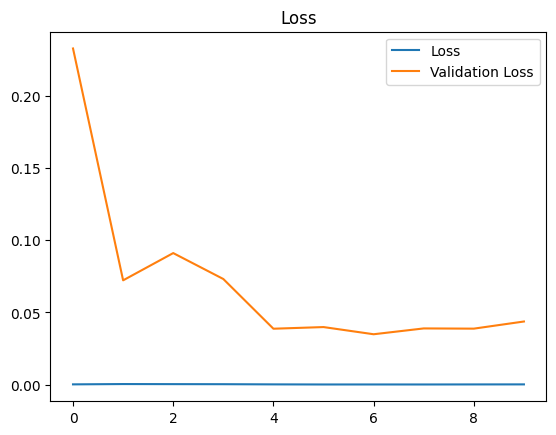

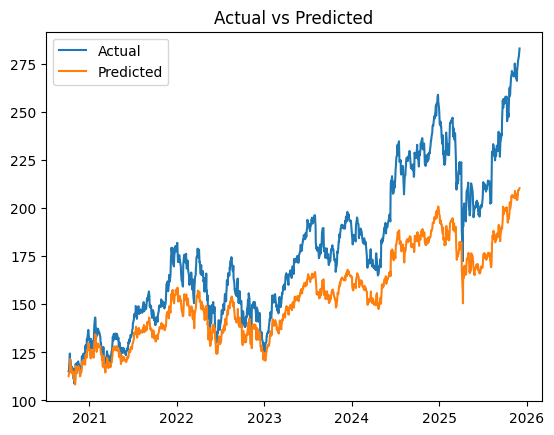

{'MAE': 23.132635346402342, 'RMSE': 28.00261216722987}

In [ ]:
# Dense = [64]
rnn_model_dense64 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, 1)),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1),
])
rnn_model_dense64.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
)

history_dense64 = rnn_model_dense64.fit(train_ds, validation_data=test_ds, epochs=10)

pred = rnn_model_dense64.predict(test_ds)
pred = scaler.inverse_transform(pred)

y_actual = get_y_actual_from_windowed_ds(test_ds, scaler)

metrics_dense64 = eval_plot_mae_rmse(history_dense64, test.index, WINDOW_SIZE, y_actual, pred)
metrics_dense64


Epoch 1/10
    651/Unknown 3s 3ms/step - loss: 2.7565e-05

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.7852e-05 - val_loss: 0.0356
Epoch 2/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0040 - val_loss: 0.1468
Epoch 3/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0082 - val_loss: 0.0353
Epoch 4/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0020 - val_loss: 0.0075
Epoch 5/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0017 - val_loss: 0.0174
Epoch 6/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.7201e-04 - val_loss: 0.0123
Epoch 7/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 7.4378e-04 - val_loss: 0.0193
Epoch 8/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.0013 - val_loss: 0.0118
Epoch 9/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.4595e-04 - val_loss: 0.0152
Epoch 10/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.0019 - val_loss: 0.0133
162/162 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step


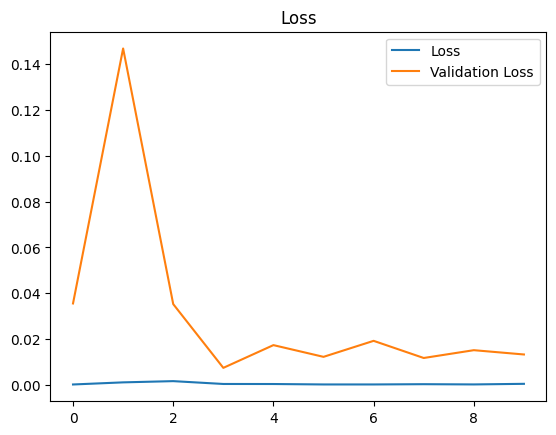

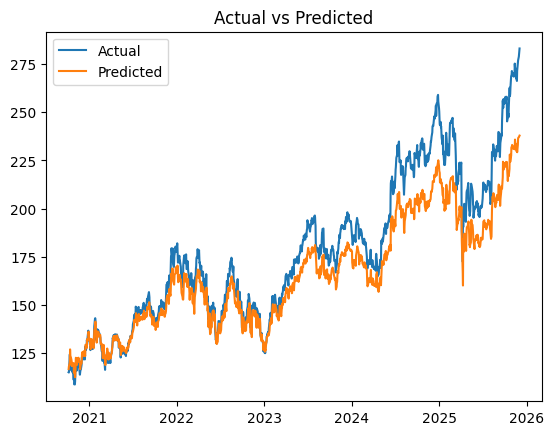

{'MAE': 11.899570544801502, 'RMSE': 15.44885842580351}

In [ ]:
# Dense = [64, 32]
rnn_model_dense64_32 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, 1)),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])
rnn_model_dense64_32.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
)

history_dense64_32 = rnn_model_dense64_32.fit(train_ds, validation_data=test_ds, epochs=10)

pred = rnn_model_dense64_32.predict(test_ds)
pred = scaler.inverse_transform(pred)

y_actual = get_y_actual_from_windowed_ds(test_ds, scaler)

metrics_dense64_32 = eval_plot_mae_rmse(history_dense64_32, test.index, WINDOW_SIZE, y_actual, pred)
metrics_dense64_32


#### Analisis

Arsitektur Dense layer berpengaruh besar terhadap hasil prediksi. Model tanpa dense hidden layer (Dense0) memberikan performa terbaik dengan MAE 9.83 dan RMSE 12.87. Penambahan Dense(64) menyebabkan penurunan akurasi yang signifikan (MAE 23.13; RMSE 28.00), sementara Dense(64,32) memberikan hasil yang lebih baik tetapi masih kalah dibanding Dense0 (MAE 11.90; RMSE 15.45). Ini menunjukkan bahwa arsitektur yang terlalu kompleks cenderung menurunkan kemampuan generalisasi.

### Eksperimen (d): Epoch & learning rate

#### Modelling

Epoch 1/20
    636/Unknown 3s 3ms/step - loss: 2.1030e-05

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 2.2240e-05 - val_loss: 0.0999
Epoch 2/20
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.9570e-04 - val_loss: 0.0424
Epoch 3/20
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - loss: 0.0033 - val_loss: 0.0125
Epoch 4/20
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.9995e-04 - val_loss: 0.0308
Epoch 5/20
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.4211e-04 - val_loss: 0.0229
Epoch 6/20
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 7.5568e-04 - val_loss: 0.0222
Epoch 7/20
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.0881e-04 - val_loss: 0.0218
Epoch 8/20
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 2.5763e-04 - val_loss: 0.0117
Epoch 9/20
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 5.0358e-04 - val_loss: 0.0175
Epoch 10/20
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.0332e-04 - val_loss: 0.0133
Epoch 11/20
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.1770e-04 - val_loss: 0.0229
Epoch 12/20
651/651 ━━━

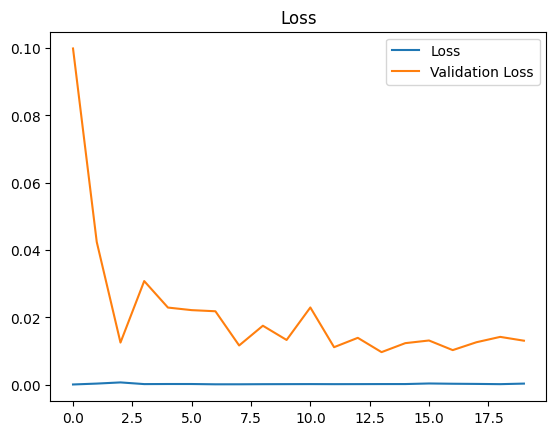

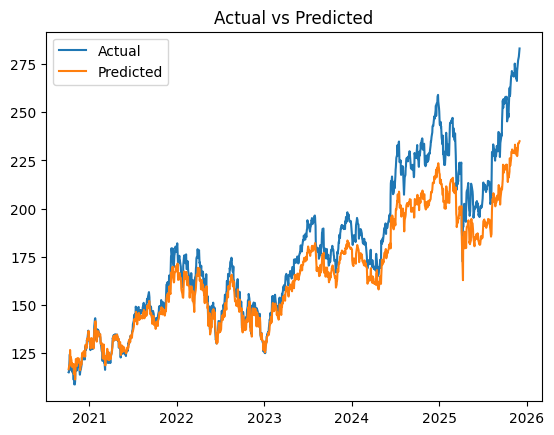

{'MAE': 11.46542509453374, 'RMSE': 15.319042534472551}

In [ ]:
# Epoch = 20, lr = 1e-3
rnn_model_e20 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, 1)),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])
rnn_model_e20.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
)

history_e20 = rnn_model_e20.fit(train_ds, validation_data=test_ds, epochs=20)

pred = rnn_model_e20.predict(test_ds)
pred = scaler.inverse_transform(pred)

y_actual = get_y_actual_from_windowed_ds(test_ds, scaler)

metrics_e20 = eval_plot_mae_rmse(history_e20, test.index, WINDOW_SIZE, y_actual, pred)
metrics_e20


Epoch 1/10
    651/Unknown 3s 3ms/step - loss: 2.5397e-05

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


651/651 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - loss: 2.5677e-05 - val_loss: 0.1421
Epoch 2/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.6396e-04 - val_loss: 0.1364
Epoch 3/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 6.4446e-04 - val_loss: 0.1126
Epoch 4/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 8.0561e-05 - val_loss: 0.1014
Epoch 5/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 1.8477e-05 - val_loss: 0.1044
Epoch 6/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.2674e-05 - val_loss: 0.0969
Epoch 7/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 7.3816e-05 - val_loss: 0.0888
Epoch 8/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 12s 3ms/step - loss: 6.5832e-05 - val_loss: 0.0820
Epoch 9/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 3.0066e-05 - val_loss: 0.0832
Epoch 10/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 2.3979e-05 - val_loss: 0.0753
162/162 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


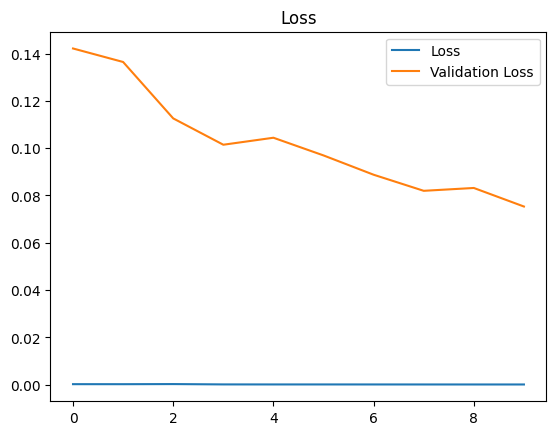

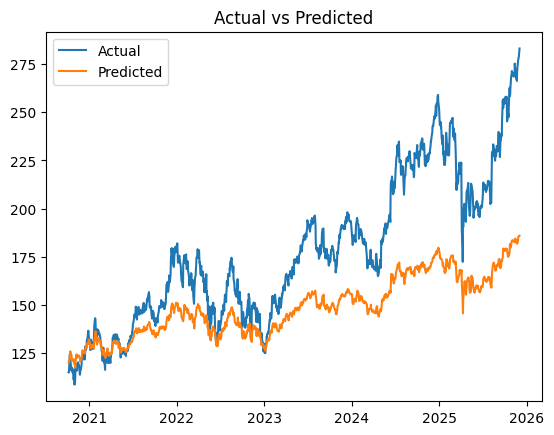

{'MAE': 29.000567847934352, 'RMSE': 36.76023623335592}

In [ ]:
# Epoch = 10, lr = 5e-4
rnn_model_lr5e4 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, 1)),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])
rnn_model_lr5e4.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
)

history_lr5e4 = rnn_model_lr5e4.fit(train_ds, validation_data=test_ds, epochs=10)

pred = rnn_model_lr5e4.predict(test_ds)
pred = scaler.inverse_transform(pred)

y_actual = get_y_actual_from_windowed_ds(test_ds, scaler)

metrics_lr5e4 = eval_plot_mae_rmse(history_lr5e4, test.index, WINDOW_SIZE, y_actual, pred)
metrics_lr5e4


#### Analisis

Pengaturan epoch dan learning rate juga memengaruhi performa model. Pelatihan selama 20 epoch menghasilkan MAE 11.47 dan RMSE 15.32, yang masih lebih baik dibanding baseline namun tidak optimal. Sebaliknya, penurunan learning rate menjadi 5e-4 menyebabkan performa menurun drastis (MAE 29.00; RMSE 36.76). Hasil ini menunjukkan bahwa epoch yang moderat dan learning rate yang cukup besar lebih sesuai untuk pelatihan RNN pada data ini.

## LSTM

#### Modelling

Epoch 1/10
    647/Unknown 8s 8ms/step - loss: 3.9031e-05

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


651/651 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - loss: 4.2270e-05 - val_loss: 0.2465
Epoch 2/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0186 - val_loss: 0.2764
Epoch 3/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0199 - val_loss: 0.1731
Epoch 4/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0378 - val_loss: 0.2926
Epoch 5/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0185 - val_loss: 0.2804
Epoch 6/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 20s 31ms/step - loss: 0.0188 - val_loss: 0.2318
Epoch 7/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0255 - val_loss: 0.4016
Epoch 8/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0225 - val_loss: 0.1994
Epoch 9/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - loss: 0.0292 - val_loss: 0.1990
Epoch 10/10
651/651 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - loss: 0.0299 - val_loss: 0.3152
162/162 ━━━━━━━━━━━━━━━━━━━━ 20s 5ms/step


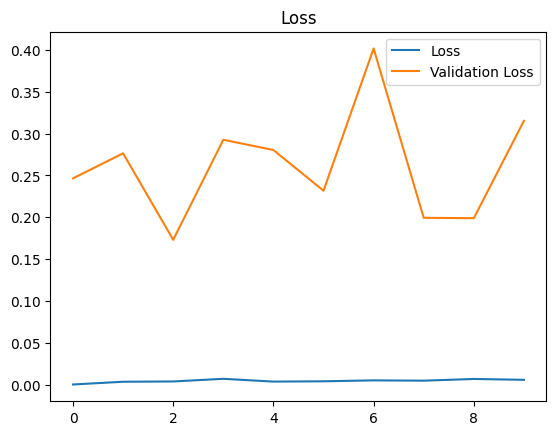

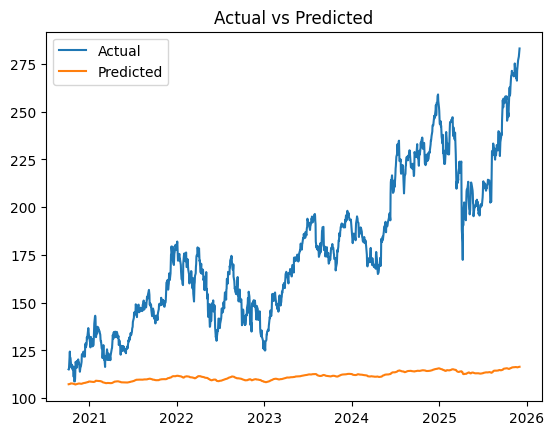

{'MAE': 65.71655018825619, 'RMSE': 75.19819305740084}

In [ ]:
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(64, return_sequences=True),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1)
  ])
lstm_model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3))
history_lstm = lstm_model.fit(train_ds, validation_data=test_ds, epochs=10)

pred = lstm_model.predict(test_ds)
pred = scaler.inverse_transform(pred)

y_actual = get_y_actual_from_windowed_ds(test_ds, scaler)

metrics = eval_plot_mae_rmse(history_lstm, test.index, WINDOW_SIZE, y_actual, pred)
metrics

#### Analisis

Model LSTM pada percobaan ini menunjukkan performa yang kurang baik dengan MAE 65.72 dan RMSE 75.20, menandakan error prediksi yang cukup besar dan deviasi yang jauh dari nilai aktual. Meskipun secara visual LSTM masih mampu mengikuti arah tren harga secara umum, prediksinya cenderung tertinggal dan tidak cukup presisi, terutama pada perubahan harga yang cepat. Sebaliknya, SimpleRNN terbaik pada percobaan terbaru memberikan error yang jauh lebih rendah (MAE 9.83, RMSE 12.87), dengan prediksi yang lebih dekat terhadap data aktual pada sebagian besar periode pengujian. Hal ini menunjukkan bahwa untuk dataset ini, SimpleRNN lebih efektif dalam menangkap pola harga jangka pendek dibandingkan LSTM.

Secara struktural, SimpleRNN lebih sederhana dan cepat dilatih, sehingga lebih sesuai untuk data dengan dependensi temporal pendek seperti window 10 langkah yang digunakan dalam eksperimen ini. Sementara itu, LSTM memiliki mekanisme gate dan cell state yang dirancang untuk menangani dependensi jangka panjang, namun kompleksitas tersebut justru tidak memberikan keuntungan pada data ini dan berpotensi menyebabkan kesulitan optimisasi. Akibatnya, meskipun LSTM secara teori lebih kuat dalam mengatasi vanishing gradient, pada kasus ini kompleksitasnya tidak sebanding dengan karakteristik data, sehingga SimpleRNN menjadi pilihan yang lebih tepat dan efisien.

# > 2020 Data

## Data Preprocessing

In [ ]:
trim_df = df[df.index >= "2020-01-01"]
train_split = 0.8
train = trim_df[int(train_split * len(trim_df)):]
test = trim_df[:int(train_split * len(trim_df))]

In [ ]:
from statsmodels.tsa.stattools import adfuller

adfuller_result = adfuller(train["Price"])

print(f"P-Value: {round(adfuller_result[1], 4)}")

P-Value: 0.8423


In [ ]:
# train_diff = train.diff().dropna()
# test_diff  = test.diff().dropna()

In [ ]:
# adfuller_result = adfuller(train_diff["Price"])

# print(f"P-Value: {round(adfuller_result[1], 4)}")

P-Value: 0.0


In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(train)
X_train = scaler.transform(train)
X_test = scaler.transform(test)

In [ ]:
WINDOW_SIZE = 10
train_ds = windowed_dataset(X_train.squeeze(1), WINDOW_SIZE, 1, 8)
test_ds = windowed_dataset(X_test.squeeze(1), WINDOW_SIZE, 1, 8)

In [ ]:
for i, j in train_ds.take(1):
    print(i.numpy().shape)
    print(j.numpy().shape)

(8, 10, 1)
(8, 1, 1)


## Modeling

### Base model

Model: "sequential_15"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_18 (SimpleRNN)       │ (None, 32)             │         1,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_30 (Dense)                │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_31 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,177 (8.50 KB)

 Trainable params: 2,177 (8.50 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
     34/Unknown 4s 14ms/step - loss: 0.0667

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


36/36 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step - loss: 0.0645 - val_loss: 0.1925
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 0.0250 - val_loss: 0.0625
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0225 - val_loss: 0.0690
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0222 - val_loss: 0.0440
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0140 - val_loss: 0.0372
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0100 - val_loss: 0.0477
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0086 - val_loss: 0.0537
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0066 - val_loss: 0.0592
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0069 - val_loss: 0.0787
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0066 - val_loss: 0.0599
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


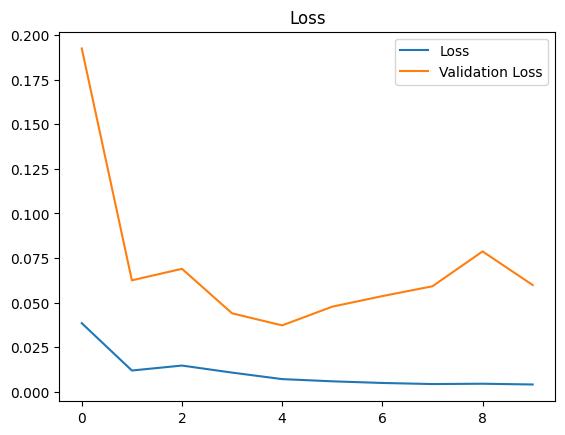

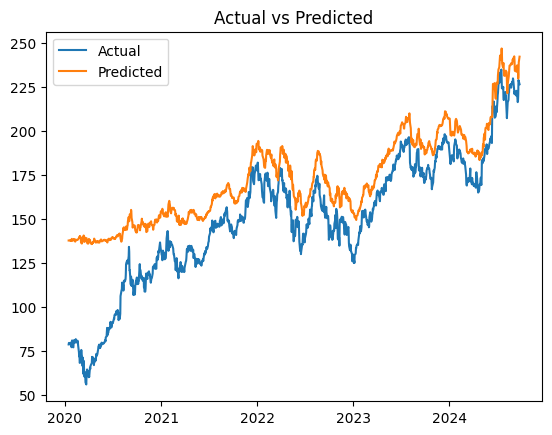

{'MAE': 22.41148547404696, 'RMSE': 27.07765679282826}

In [ ]:
# base
rnn_model_base_2020 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, 1)),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])
rnn_model_base_2020.summary()

rnn_model_base_2020.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
)

history_base_2020 = rnn_model_base_2020.fit(train_ds, validation_data=test_ds, epochs=10)

pred = rnn_model_base_2020.predict(test_ds)
pred = scaler.inverse_transform(pred)

y_actual = get_y_actual_from_windowed_ds(test_ds, scaler)

metrics_2020 = eval_plot_mae_rmse(history_base_2020, test.index, WINDOW_SIZE, y_actual, pred)
metrics_2020

### Eksperimen (a): Jumlah neuron pada RNN layer

#### Modelling

Epoch 1/10
     28/Unknown 3s 6ms/step - loss: 0.3607

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.3267 - val_loss: 0.0829
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0336 - val_loss: 0.1146
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0068 - val_loss: 0.1169
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0055 - val_loss: 0.0902
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0063 - val_loss: 0.1086
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0068 - val_loss: 0.1250
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0067 - val_loss: 0.1321
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0054 - val_loss: 0.1450
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0043 - val_loss: 0.1396
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0042 - val_loss: 0.1388
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


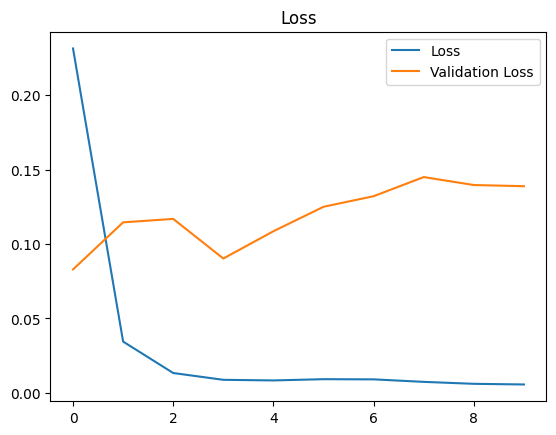

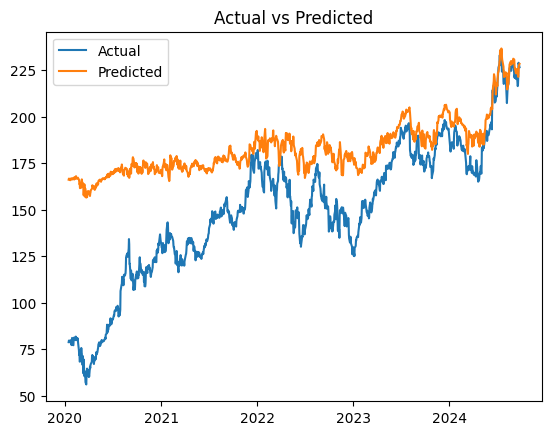

{'MAE': 32.73824280665222, 'RMSE': 41.240313985082885}

In [ ]:
# Units = 16
rnn_model_u16_2020 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, 1)),
    tf.keras.layers.SimpleRNN(16),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])
rnn_model_u16_2020.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
)

history_u16_2020 = rnn_model_u16_2020.fit(train_ds, validation_data=test_ds, epochs=10)

pred = rnn_model_u16_2020.predict(test_ds)
pred = scaler.inverse_transform(pred)

y_actual = get_y_actual_from_windowed_ds(test_ds, scaler)

metrics_u16_2020 = eval_plot_mae_rmse(history_u16_2020, test.index, WINDOW_SIZE, y_actual, pred)
metrics_u16_2020

Epoch 1/10
     35/Unknown 4s 8ms/step - loss: 0.0533

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 33ms/step - loss: 0.0515 - val_loss: 0.0527
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0199 - val_loss: 0.0722
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0132 - val_loss: 0.0775
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.0093 - val_loss: 0.0799
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0068 - val_loss: 0.0830
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0044 - val_loss: 0.0659
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0025 - val_loss: 0.0843
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 38ms/step - loss: 0.0039 - val_loss: 0.0813
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0041 - val_loss: 0.1155
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0041 - val_loss: 0.0838
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step


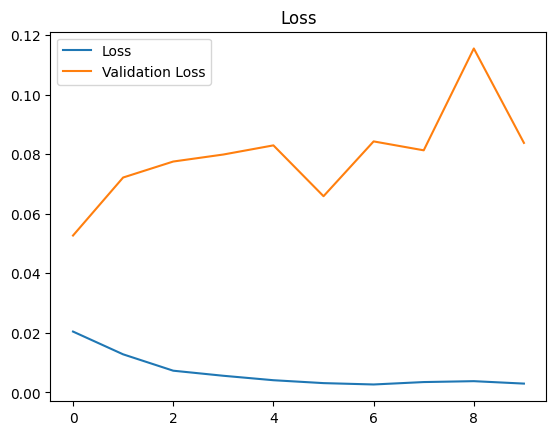

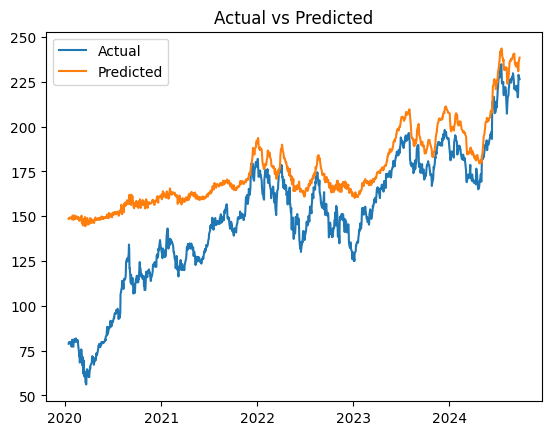

{'MAE': 25.77153871647881, 'RMSE': 32.03622142157009}

In [ ]:
# Units = 64
rnn_model_u64_2020 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, 1)),
    tf.keras.layers.SimpleRNN(64),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])
rnn_model_u64_2020.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
)

history_u64_2020 = rnn_model_u64_2020.fit(train_ds, validation_data=test_ds, epochs=10)

pred = rnn_model_u64_2020.predict(test_ds)
pred = scaler.inverse_transform(pred)

y_actual = get_y_actual_from_windowed_ds(test_ds, scaler)

metrics_u64_2020 = eval_plot_mae_rmse(history_u64_2020, test.index, WINDOW_SIZE, y_actual, pred)
metrics_u64_2020


#### Analisis

Variasi jumlah neuron pada RNN layer berdampak signifikan terhadap performa model. Pada subset data >2020, 16 unit menghasilkan MAE 32,74 dan RMSE 41,24 dengan prediksi cenderung datar, menandakan underfitting akibat kapasitas terlalu kecil. sedangkan 64 unit menurunkan error menjadi MAE 25,77 dan RMSE 32,04, dengan prediksi lebih mendekati data aktual. Perbandingan dengan full data menunjukkan tren yang sama, model dengan 16 unit underfitting karena kapasitas terlalu kecil, 32 unit membaik, dan performa terbaik dicapai pada 64 unit, menegaskan bahwa peningkatan jumlah neuron hingga titik tertentu secara konsisten meningkatkan kemampuan RNN menangkap pola temporal.

### Eksperimen (b): Jumlah RNN layer

#### Modelling

Epoch 1/10
     35/Unknown 47s 6ms/step - loss: 0.0153

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


36/36 ━━━━━━━━━━━━━━━━━━━━ 48s 31ms/step - loss: 0.0150 - val_loss: 0.0667
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0389 - val_loss: 0.0530
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0417 - val_loss: 0.1346
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0525 - val_loss: 0.0850
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0482 - val_loss: 0.0391
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0314 - val_loss: 0.0271
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0206 - val_loss: 0.0179
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0144 - val_loss: 0.0214
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0110 - val_loss: 0.0257
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 0.0109 - val_loss: 0.0672
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


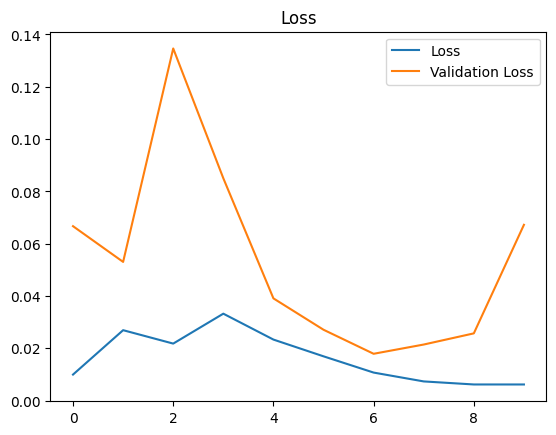

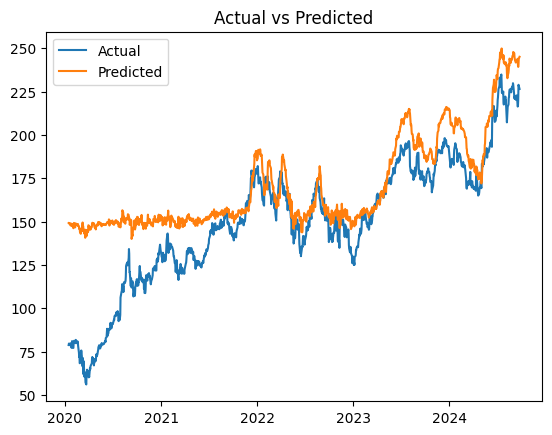

{'MAE': 20.756614867025153, 'RMSE': 28.694765100765682}

In [ ]:
# 2 RNN layers (32 units)
rnn_model_rnn2_2020 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, 1)),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])
rnn_model_rnn2_2020.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
)

history_rnn2_2020 = rnn_model_rnn2_2020.fit(train_ds, validation_data=test_ds, epochs=10)

pred = rnn_model_rnn2_2020.predict(test_ds)
pred = scaler.inverse_transform(pred)

y_actual = get_y_actual_from_windowed_ds(test_ds, scaler)

metrics_rnn2_2020 = eval_plot_mae_rmse(history_rnn2_2020, test.index, WINDOW_SIZE, y_actual, pred)
metrics_rnn2_2020


Epoch 1/10
     32/Unknown 4s 9ms/step - loss: 0.0938

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 40ms/step - loss: 0.0852 - val_loss: 0.2864
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0508 - val_loss: 0.2257
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0800 - val_loss: 0.2207
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0788 - val_loss: 0.1696
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0737 - val_loss: 0.1569
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 40ms/step - loss: 0.0818 - val_loss: 0.1448
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 0.0571 - val_loss: 0.0752
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0336 - val_loss: 0.1099
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0699 - val_loss: 0.1082
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0615 - val_loss: 0.1038
148/148 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step


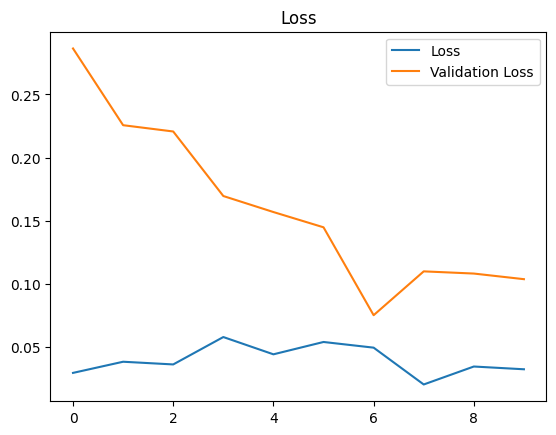

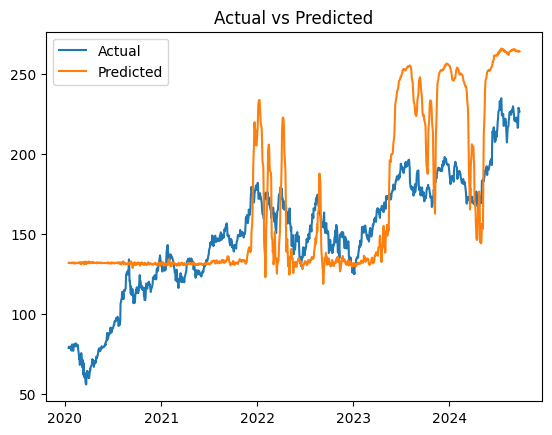

{'MAE': 28.74632900325397, 'RMSE': 35.65063218021242}

In [ ]:
# 3 RNN layers (32 units)
rnn_model_rnn3_2020 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, 1)),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])
rnn_model_rnn3_2020.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
)

history_rnn3_2020 = rnn_model_rnn3_2020.fit(train_ds, validation_data=test_ds, epochs=10)

pred = rnn_model_rnn3_2020.predict(test_ds)
pred = scaler.inverse_transform(pred)

y_actual = get_y_actual_from_windowed_ds(test_ds, scaler)

metrics_rnn3_2020 = eval_plot_mae_rmse(history_rnn3_2020, test.index, WINDOW_SIZE, y_actual, pred)
metrics_rnn3_2020


#### Analisis

Dengan 32 unit per layer, model 2 layer menghasilkan MAE 20,76 dan RMSE 28,69, sedangkan penambahan menjadi 3 layer justru meningkatkan error (MAE 28,75, RMSE 35,65), menunjukkan performa menurun. Sama halnya dengan model full data, 2 layer memberikan MAE 29,91 dan RMSE 38,68, sementara 3 layer justru sangat buruk (MAE 76,37 ,RMSE 86,34). Hal ini karena SimpleRNN yang rentan terhadap vanishing gradient ketika lapisan terlalu dalam, sehingga satu layer terbukti paling stabil dan optimal untuk dataset ini.

### Eksperimen (c): Dense layer & neuron

#### Modelling

Epoch 1/10
     30/Unknown 4s 7ms/step - loss: 0.5905

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 37ms/step - loss: 0.5358 - val_loss: 0.0574
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 27ms/step - loss: 0.0300 - val_loss: 0.0303
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0247 - val_loss: 0.0282
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0250 - val_loss: 0.0255
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0239 - val_loss: 0.0215
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0222 - val_loss: 0.0179
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0203 - val_loss: 0.0149
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step - loss: 0.0184 - val_loss: 0.0126
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0167 - val_loss: 0.0107
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0152 - val_loss: 0.0092
148/148 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


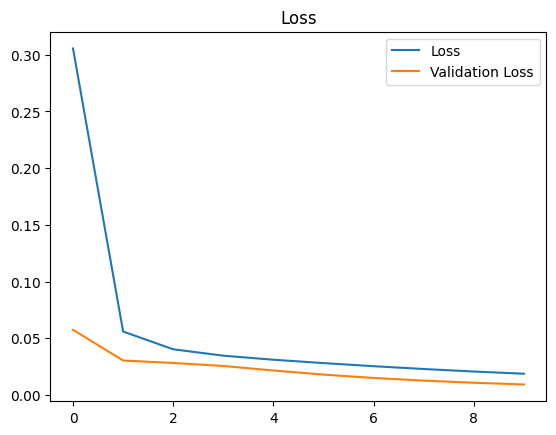

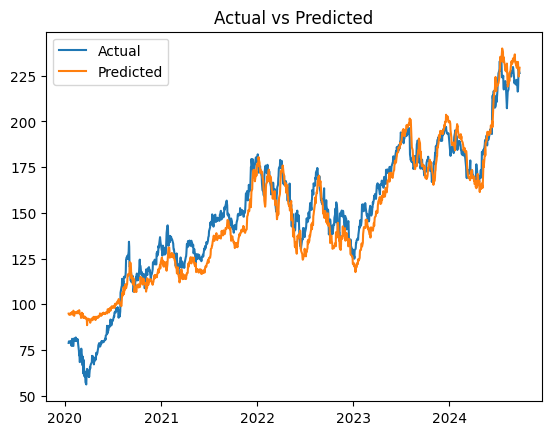

{'MAE': 8.665670799663049, 'RMSE': 10.609972394381867}

In [ ]:
# Dense = 0 (langsung output)
rnn_model_dense0_2020 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, 1)),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1),
])
rnn_model_dense0_2020.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
)

history_dense0_2020 = rnn_model_dense0_2020.fit(train_ds, validation_data=test_ds, epochs=10)

pred = rnn_model_dense0_2020.predict(test_ds)
pred = scaler.inverse_transform(pred)

y_actual = get_y_actual_from_windowed_ds(test_ds, scaler)

metrics_dense0_2020 = eval_plot_mae_rmse(history_dense0_2020, test.index, WINDOW_SIZE, y_actual, pred)
metrics_dense0_2020


Epoch 1/10
     30/Unknown 3s 9ms/step - loss: 0.0060

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 41ms/step - loss: 0.0058 - val_loss: 0.3580
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0077 - val_loss: 0.2979
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0071 - val_loss: 0.3198
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.0086 - val_loss: 0.2692
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0078 - val_loss: 0.2736
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0040 - val_loss: 0.2824
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 87ms/step - loss: 0.0023 - val_loss: 0.2906
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0020 - val_loss: 0.3005
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0019 - val_loss: 0.3087
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0019 - val_loss: 0.3147
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


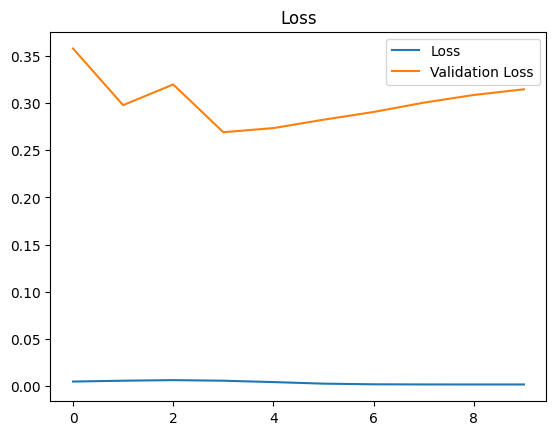

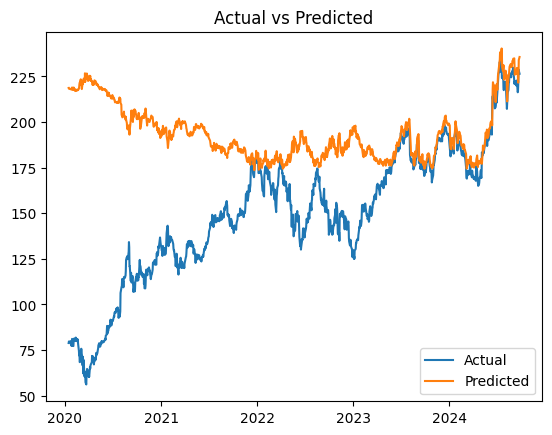

{'MAE': 43.7914457939478, 'RMSE': 62.08660032728781}

In [ ]:
# Dense = [64]
rnn_model_dense64_2020 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, 1)),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(1),
])
rnn_model_dense64_2020.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
)

history_dense64_2020 = rnn_model_dense64_2020.fit(train_ds, validation_data=test_ds, epochs=10)

pred = rnn_model_dense64_2020.predict(test_ds)
pred = scaler.inverse_transform(pred)

y_actual = get_y_actual_from_windowed_ds(test_ds, scaler)

metrics_dense64_2020 = eval_plot_mae_rmse(history_dense64_2020, test.index, WINDOW_SIZE, y_actual, pred)
metrics_dense64_2020


Epoch 1/10
     36/Unknown 4s 8ms/step - loss: 0.0692

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 39ms/step - loss: 0.0681 - val_loss: 0.1019
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.0307 - val_loss: 0.0860
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0228 - val_loss: 0.0747
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 82ms/step - loss: 0.0187 - val_loss: 0.0906
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0185 - val_loss: 0.1110
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0203 - val_loss: 0.1018
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0090 - val_loss: 0.1023
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0111 - val_loss: 0.1053
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 152ms/step - loss: 0.0099 - val_loss: 0.1283
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0056 - val_loss: 0.1369
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


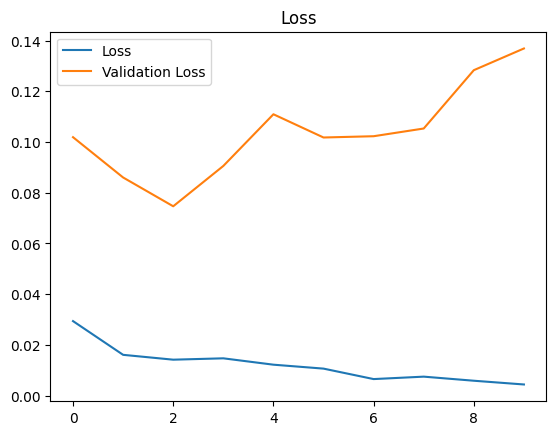

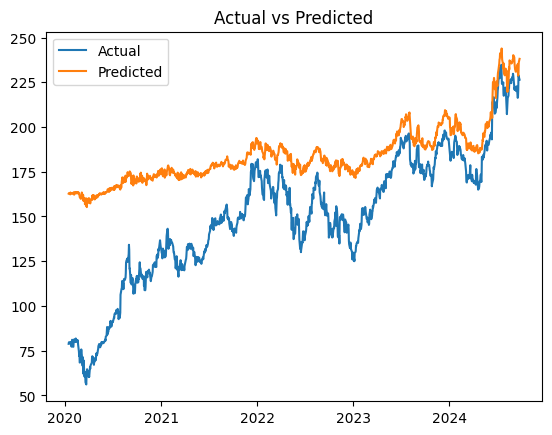

{'MAE': 33.94468801354432, 'RMSE': 40.95052998807133}

In [ ]:
# Dense = [64, 32]
rnn_model_dense64_32_2020 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, 1)),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])
rnn_model_dense64_32_2020.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
)

history_dense64_32_2020 = rnn_model_dense64_32_2020.fit(train_ds, validation_data=test_ds, epochs=10)

pred = rnn_model_dense64_32_2020.predict(test_ds)
pred = scaler.inverse_transform(pred)

y_actual = get_y_actual_from_windowed_ds(test_ds, scaler)

metrics_dense64_32_2020 = eval_plot_mae_rmse(history_dense64_32_2020, test.index, WINDOW_SIZE, y_actual, pred)
metrics_dense64_32_2020


#### Analisis

Model paling sederhana tanpa dense layer memberikan hasil terbaik (MAE 8,67; RMSE 10,61), sementara penambahan Dense(64) menurunkan performa secara drastis (MAE 43,79; RMSE 62,09) dan Dense(64, 32) memperburuknya lebih jauh (MAE 33,94; RMSE 40,95). Perbandingan dengan full data menunjukkan tren yang mirip yaitu model tanpa dense layer terbaik (MAE 7,26; RMSE 9,52), Dense(64) menurunkan akurasi (MAE 15,73; RMSE 18,50), dan Dense(64, 32) memperburuk performa ekstrem (MAE 31,22; RMSE 39,10). Hasil ini menegaskan bahwa penambahan dense layer yang besar menyebabkan model menangkap noise, sehingga kemampuan generalisasi menurun.

### Eksperimen (d): Epoch & learning rate

#### Modelling

Epoch 1/20
     26/Unknown 2s 4ms/step - loss: 0.1526

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.1261 - val_loss: 0.0854
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0162 - val_loss: 0.1186
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0112 - val_loss: 0.1193
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0100 - val_loss: 0.1220
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0082 - val_loss: 0.1203
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0076 - val_loss: 0.1210
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0060 - val_loss: 0.1284
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 0.0047 - val_loss: 0.1384
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0039 - val_loss: 0.1441
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - loss: 0.0034 - val_loss: 0.1497
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0030 - val_loss: 0.1558
Epoch 12/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0028 - val_l

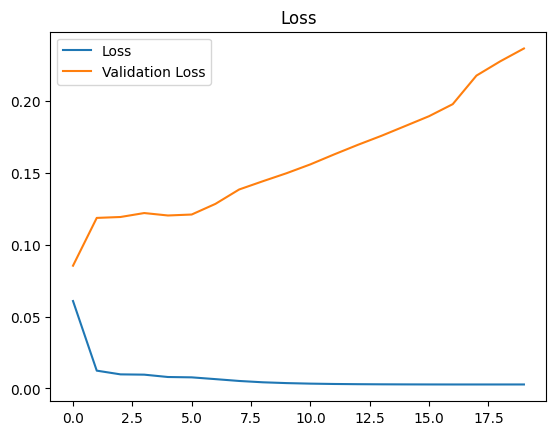

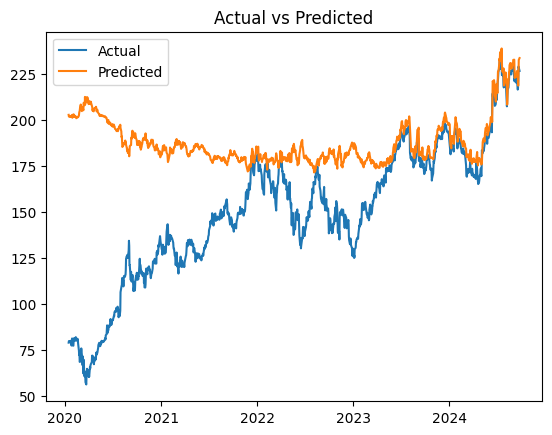

{'MAE': 37.724613967390766, 'RMSE': 53.8179081989102}

In [ ]:
# Epoch = 20, lr = 1e-3
rnn_model_e20_2020 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, 1)),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])
rnn_model_e20_2020.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
)

history_e20_2020 = rnn_model_e20_2020.fit(train_ds, validation_data=test_ds, epochs=20)

pred = rnn_model_e20_2020.predict(test_ds)
pred = scaler.inverse_transform(pred)

y_actual = get_y_actual_from_windowed_ds(test_ds, scaler)

metrics_e20_2020 = eval_plot_mae_rmse(history_e20_2020, test.index, WINDOW_SIZE, y_actual, pred)
metrics_e20_2020


Epoch 1/10
     25/Unknown 2s 4ms/step - loss: 0.3134

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.2533 - val_loss: 0.0346
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0044 - val_loss: 0.0395
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0075 - val_loss: 0.0447
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0094 - val_loss: 0.0477
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0097 - val_loss: 0.0512
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0089 - val_loss: 0.0487
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0077 - val_loss: 0.0556
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 0.0073 - val_loss: 0.0533
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0063 - val_loss: 0.0596
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0057 - val_loss: 0.0574
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


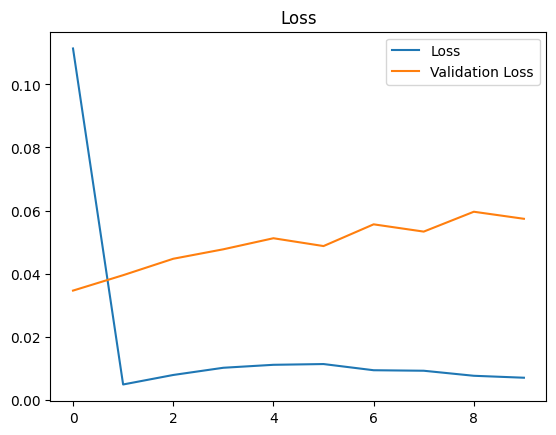

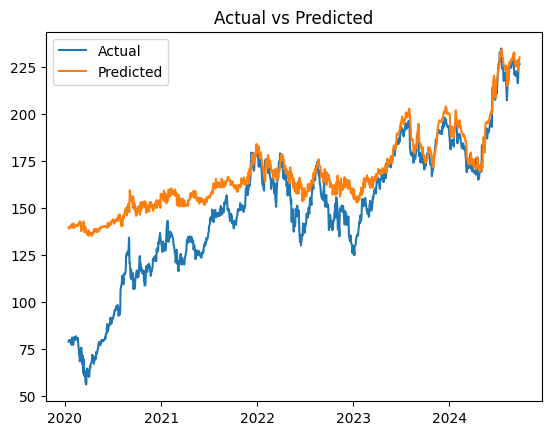

{'MAE': 18.835040551364372, 'RMSE': 26.515264592924396}

In [ ]:
# Epoch = 10, lr = 5e-4
rnn_model_lr5e4_2020 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, 1)),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(32, activation="relu"),
    tf.keras.layers.Dense(1),
])
rnn_model_lr5e4_2020.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=5e-4),
)

history_lr5e4_2020 = rnn_model_lr5e4_2020.fit(train_ds, validation_data=test_ds, epochs=10)

pred = rnn_model_lr5e4_2020.predict(test_ds)
pred = scaler.inverse_transform(pred)

y_actual = get_y_actual_from_windowed_ds(test_ds, scaler)

metrics_lr5e4_2020 = eval_plot_mae_rmse(history_lr5e4_2020, test.index, WINDOW_SIZE, y_actual, pred)
metrics_lr5e4_2020

#### Analisis

Pelatihan 20 epoch dengan lr 1e-3 menghasilkan MAE 37,72 dan RMSE 53,82, sedangkan 10 epoch dengan lr 5e-4 menurunkan error signifikan (MAE 18,84; RMSE 26,52), menunjukkan bahwa kombinasi epoch moderat dan learning rate tepat lebih efektif. Pada model full data memiliki tren yang mirip, 10 epoch memberikan performa paling stabil (MAE 7,26; RMSE 9,52), sementara 20 epoch menurunkan akurasi (MAE 12,97; RMSE 17,05), dan learning rate terlalu kecil (5e-4) membuat model gagal mencapai minima optimal (MAE 20,25; RMSE 25,75). Hasil ini menegaskan bahwa pengaturan epoch dan learning rate seimbang penting untuk menangkap pola temporal tanpa kehilangan titik optimum.

### LSTM

#### Modelling

Epoch 1/10
     34/Unknown 4s 6ms/step - loss: 0.1521

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


36/36 ━━━━━━━━━━━━━━━━━━━━ 4s 26ms/step - loss: 0.1454 - val_loss: 0.1021
Epoch 2/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0096 - val_loss: 0.0923
Epoch 3/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0102 - val_loss: 0.0814
Epoch 4/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0083 - val_loss: 0.0714
Epoch 5/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step - loss: 0.0071 - val_loss: 0.0639
Epoch 6/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0066 - val_loss: 0.0586
Epoch 7/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0063 - val_loss: 0.0548
Epoch 8/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0060 - val_loss: 0.0520
Epoch 9/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0058 - val_loss: 0.0499
Epoch 10/10
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0056 - val_loss: 0.0482
148/148 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step


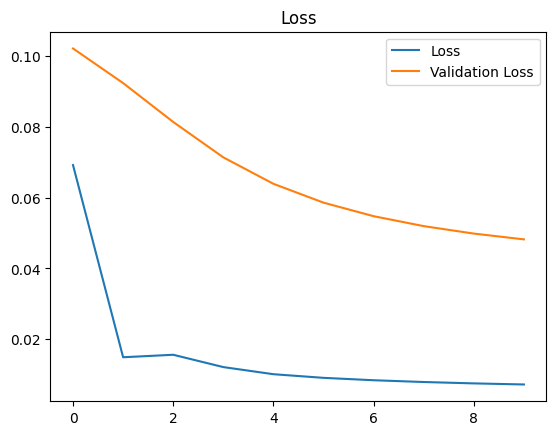

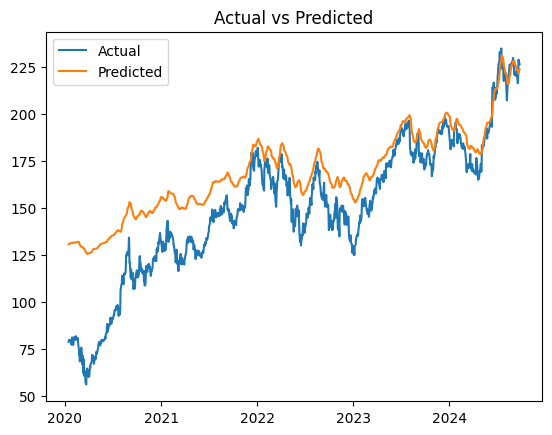

{'MAE': 19.183749578086072, 'RMSE': 24.303978856958512}

In [ ]:
# Dense = 0 (langsung output) - LSTM
lstm_model_dense0_2020 = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=(WINDOW_SIZE, 1)),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(1),
])

lstm_model_dense0_2020.compile(
    loss="mse",
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
)

history_lstm_dense0_2020 = lstm_model_dense0_2020.fit(
    train_ds,
    validation_data=test_ds,
    epochs=10
)

pred_lstm = lstm_model_dense0_2020.predict(test_ds)
pred_lstm = scaler.inverse_transform(pred_lstm)

y_actual = get_y_actual_from_windowed_ds(test_ds, scaler)

metrics_lstm_dense0_2020 = eval_plot_mae_rmse(history_lstm_dense0_2020,test.index,WINDOW_SIZE,y_actual,pred_lstm)

metrics_lstm_dense0_2020


#### Analisis

Model LSTM memberikan performa stabil dengan MAE 19.18 dan RMSE 24.30, di mana visualisasinya konsisten mengikuti tren harga meski terdapat selisih di awal periode. Sementara, SimpleRNN memiliki error lebih rendah (MAE 8.66, RMSE 10.60) dengan prediksi yang sangat dekat pada data aktual di akhir periode, namun grafik loss LSTM menunjukkan generalisasi yang lebih halus. Hal ini terjadi karena LSTM memiliki mekanisme gate untuk mengatasi vanishing gradient, sehingga lebih baik dalam menangkap dependensi jangka panjang dibandingkan SimpleRNN yang hanya efektif untuk pola jangka pendek.

Secara struktural, SimpleRNN unggul dalam kecepatan komputasi karena layer yang sederhana, tetapi lemah dalam mengingat informasi masa lalu yang jauh. Sebaliknya, LSTM memiliki cell state sebagai memori jangka panjang yang mampu mempertahankan informasi relevan dalam sekuens panjang, menjadikannya lebih robust untuk data saham. Meskipun membutuhkan waktu training lebih lama dan sumber daya lebih besar, LSTM memitigasi risiko hilangnya konteks historis yang sering dialami oleh RNN standar.

# Evaluation

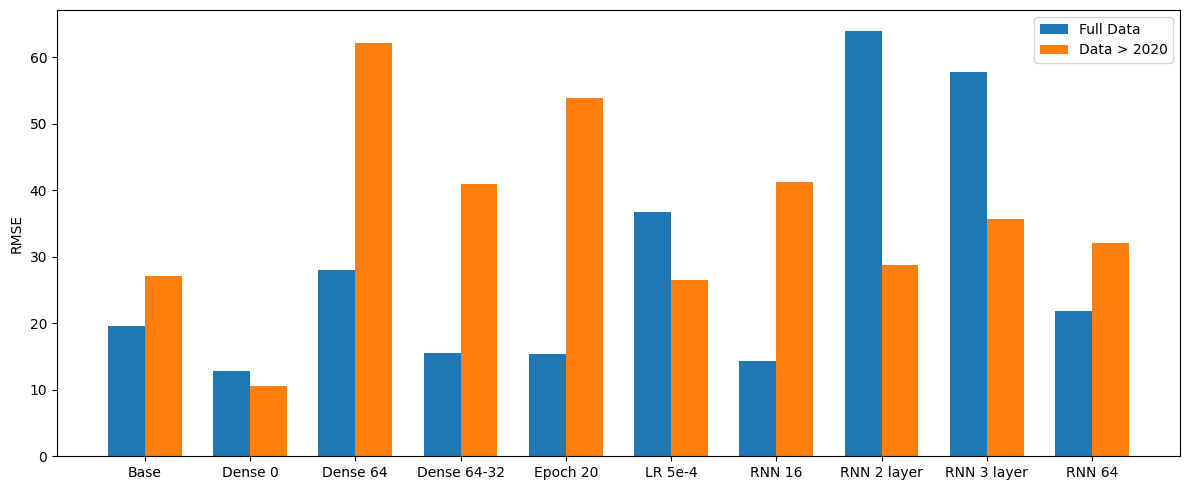

In [ ]:
results = {
    "Full Data": {
        "Base": {"MAE": 15.3796, "RMSE": 19.5682},
        "RNN 16": {"MAE": 11.3031, "RMSE": 14.3484},
        "RNN 64": {"MAE": 19.2459, "RMSE": 21.8056},
        "RNN 2 layer": {"MAE": 55.4077, "RMSE": 63.8789},
        "RNN 3 layer": {"MAE": 47.6060, "RMSE": 57.7658},
        "Dense 0": {"MAE": 9.8257, "RMSE": 12.8715},
        "Dense 64": {"MAE": 23.1326, "RMSE": 28.0026},
        "Dense 64-32": {"MAE": 11.8996, "RMSE": 15.4489},
        "Epoch 20": {"MAE": 11.4654, "RMSE": 15.3190},
        "LR 5e-4": {"MAE": 29.0006, "RMSE": 36.7602},
    },
    "Data > 2020": {
        "Base": {"MAE": 22.4115, "RMSE": 27.0777},
        "RNN 16": {"MAE": 32.7382, "RMSE": 41.2403},
        "RNN 64": {"MAE": 25.7715, "RMSE": 32.0362},
        "RNN 2 layer": {"MAE": 20.7566, "RMSE": 28.6948},
        "RNN 3 layer": {"MAE": 28.7463, "RMSE": 35.6506},
        "Dense 0": {"MAE": 8.6657, "RMSE": 10.6100},
        "Dense 64": {"MAE": 43.7914, "RMSE": 62.0866},
        "Dense 64-32": {"MAE": 33.9447, "RMSE": 40.9505},
        "Epoch 20": {"MAE": 37.7246, "RMSE": 53.8179},
        "LR 5e-4": {"MAE": 18.8350, "RMSE": 26.5153},
    }
}

rows = []
for dataset, models in results.items():
    for model, metric in models.items():
        rows.append({
            "Dataset": dataset,
            "Model": model,
            "MAE": metric["MAE"],
            "RMSE": metric["RMSE"]
        })

df_metrics = pd.DataFrame(rows)
df_metrics.sort_values(by=["Dataset", "MAE"])
df_full = df_metrics[df_metrics["Dataset"] == "Full Data"]
df_2020 = df_metrics[df_metrics["Dataset"] == "Data > 2020"]
df_full = df_full.sort_values("Model")
df_2020 = df_2020.sort_values("Model")

x = np.arange(len(df_full))
w = 0.35

plt.figure(figsize=(12,5))
plt.bar(x - w/2, df_full["RMSE"], w, label="Full Data")
plt.bar(x + w/2, df_2020["RMSE"], w, label="Data > 2020")

plt.xticks(x, df_full["Model"])
plt.ylabel("RMSE")
plt.legend()
plt.tight_layout()
plt.show()

Secara keseluruhan, hasil eksperimen menunjukkan beberapa pola yang jelas yaitu model RNN dengan jumlah neuron yang cukup (misal 64) dan satu layer umumnya lebih baik dalam menangkap pola temporal dibandingkan jumlah neuron sedikit atau RNN yang terlalu dalam, karena lapisan berlebih cenderung menimbulkan masalah vanishing gradient. Penambahan dense layer besar justru menurunkan performa, karena model cenderung menangkap noise, sedangkan model tanpa dense layer menunjukkan hasil terbaik. Selain itu, pengaturan epoch dan learning rate harus seimbang; terlalu banyak epoch atau learning rate terlalu kecil membuat model kehilangan titik optimum.

Pada percobaan ke kedua data (Full data dan data>2020) , model paling bagus adalah RNN dengan satu layer, tanpa dense layer, dan epoch moderat (memberikan MAE/RMSE terendah baik pada full data maupun data >2020), sedangkan model paling buruk adalah kombinasi dense layer besar atau RNN terlalu dalam, yang menghasilkan error tertinggi dan performa sangat buruk.